In [1]:
%pip install -U -q google-generativeai
%pip install -q tqdm
%pip install -q scikit-learn
%pip install -q matplotlib
%pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import google.generativeai as genai
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [3]:
tqdm.pandas()

In [4]:
API_KEY = os.environ.get('GOOGLE_API_KEY')

genai.configure(api_key=API_KEY)

In [5]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001
models/text-embedding-004


In [6]:
convs = pd.read_csv('stjohns.csv')
convs = convs[convs['author'] == 'USER']
convs

,short_name,id,conversation,flow_id,timestamp,content,answer_type,failed,author
0,stjohns,1,1,F38211883137QDUCKE,2025-01-21T22:25:06.797000Z,What is my GPA?,NaN,False,USER
2,stjohns,3,2,F382118841665YTP21,2025-01-21T22:28:45.996000Z,What is my gpa?,NaN,False,USER
4,stjohns,5,2,F672655459266TA1NPW,2025-01-21T22:29:00.041000Z,Who are my advisors?,NaN,False,USER
6,stjohns,7,2,F38211884424Z5YG4I,2025-01-21T22:29:17.658000Z,Do I have any holds?,NaN,False,USER
8,stjohns,9,2,F38211884697A3JI4V,2025-01-21T22:29:41.216000Z,What is my balance?,NaN,False,USER
...,...,...,...,...,...,...,...,...,...
126,stjohns,127,40,F503088875280A0V4WS,2025-01-23T20:18:47.369000Z,how do i register for classes,NaN,False,USER
128,stjohns,129,41,F787314681637RGUHPU,2025-01-27T16:07:58.863000Z,Where is IT located?,NaN,False,USER
130,stjohns,131,41,F10633754359734Z2VMP,2025-01-27T16:08:41.778000Z,Who is David Park?,NaN,False,USER
132,stjohns,133,42,F1703038121777RNI2SZ,2025-01-27T16:27:39.337000Z,How do I schedule an appointment with IT?,NaN,False,USER


In [7]:
def make_embed_text_fn(model):
  #@retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="SEMANTIC_SIMILARITY")
    return embedding["embedding"]
  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['content'].progress_apply(make_embed_text_fn(model))
  return df

In [8]:
convs = create_embeddings(convs)

  0%|          | 0/68 [00:00<?, ?it/s]

In [9]:
X = np.array(convs['Embeddings'].to_list(), dtype=np.float32)
X.shape

(68, 768)

# T-SNE

In [10]:
tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

In [11]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
#df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne


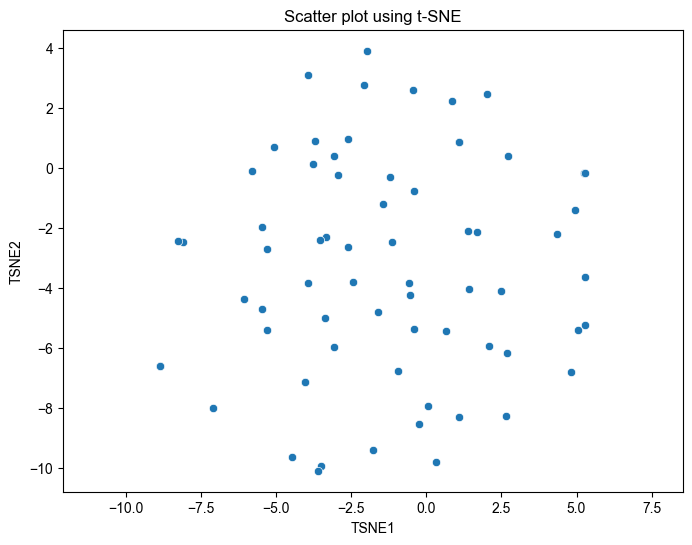

In [12]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2')
plt.title('Scatter plot using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal');

# KMeans

In [13]:
kmeans_model = KMeans(n_clusters=6, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)
df_tsne['Cluster'] = labels

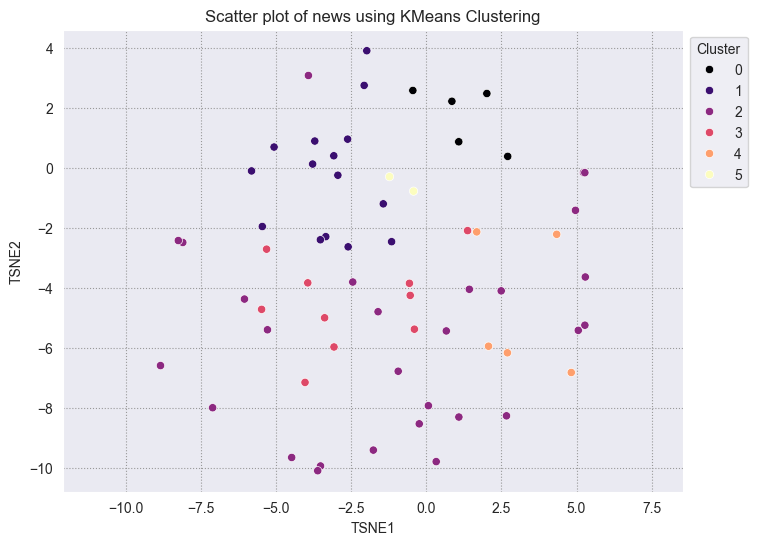

In [14]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using KMeans Clustering');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal');

In [33]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [40]:
convs[labels == 0]['content'].unique()

array(['IT Service Desk',
       'Where is the Marillac IT service center located',
       'what is the IT number', 'Where is IT located?',
       'How do I schedule an appointment with IT?'], dtype=object)

In [41]:
convs[labels == 1]['content'].unique()

array(['What is my GPA?', 'What is my gpa?', 'Who are my advisors?',
       'Do I have any holds?', 'What is my balance?',
       'What is my class schedule?', 'What is my schedule?',
       'How do I change my major?', 'what is my gpa',
       'What is my GPA currently', 'What does my schedule look like',
       'How do you drop a class', "What's my GPA",
       'what is my stormcard id number', 'what is my x number'],
      dtype=object)

In [42]:
convs[labels == 2]['content'].unique()

array(["I'd like to rate this conversation.",
       'I’d like to rate this conversation too.', 'Greetings!',
       'Getting there.',
       'Use this chat to test my responses with different relevance & weight values.',
       'One last time.', 'Can you find people in the directory?',
       'Within Connect, there is a Directory. Can you access people in it?',
       'Find me information on Brendan Monahan.',
       'How can I email professor Alvarado?', 'Who is Roger So?',
       'What is the value of pi to the 39th value',
       'I need to contact Eric Alvarado', 'Contact Eric Alvarado',
       'Microsoft Teams.', 'can you tell me more', 'Gaming', 'Esports',
       'How do I make cheese', 'What campuses are there?',
       'what is our mascot', 'what are the hours for the gym',
       'how do i register an overnight guest',
       'where is the university located', 'how much is the tuition',
       'employment opportunities', 'how do I apply for housing',
       'Who is David Park

In [43]:
convs[labels == 3]['content'].unique()

array(['How do I register for courses?', 'show me the academic calendar',
       'who should i contact about graduating',
       'how can i find my academic advisor',
       'when is the deadline for graduate programs',
       'is there a map of the campus', 'what is the final exam schedule',
       'how do i request a transcript',
       'what is the link for the registrar',
       'how do i register for classes'], dtype=object)

In [44]:
convs[labels == 4]['content'].unique()

array(['Chatbot', 'transcript', 'how do i login as an authorized user',
       'queens', 'password'], dtype=object)

In [45]:
convs[labels == 5]['content'].unique()

array(['do you have nursing as a major',
       'what majors are available at st johns'], dtype=object)